# Corendering more attributes

This Notebook goes with a blog post, *[Corendering more attributes](http://www.agilegeoscience.com/blog/2015/6/11/corendering-more-attributes)*, at Agile Geoscience.

The idea is to reproduce the horizon used in Matt's post *[Colouring maps](http://www.agilegeoscience.com/blog/2013/8/29/colouring-maps.html)*, but maybe not with the fold-modulating-opacity bit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

## Load and pre-condition the data

In [2]:
amp_raw = np.loadtxt('data/FS4_Amp.txt')
sim_raw = np.loadtxt('data/FS4_Sim.txt')

In [3]:
np.amax(sim_raw)

1e+30

We need to deal with the null values, and turn them into NumPy NaNs.

In [4]:
nulls = np.amax(amp_raw)

In [5]:
np.place(amp_raw, amp_raw==nulls, np.nan)
np.place(sim_raw, sim_raw==nulls, np.nan)

In [6]:
np.amax(sim_raw)

nan

The 'raw' files are just long arrays with inline, xline, elevation (ms) and amplitude or similarity:

In [7]:
sim_raw[:3]

array([[  1.04000000e+02,   3.02000000e+02,   1.12565780e+03,
          8.71300000e-01],
       [  1.04000000e+02,   3.03000000e+02,   1.12561238e+03,
          8.98682000e-01],
       [  1.04000000e+02,   3.04000000e+02,   1.12549269e+03,
          8.95808000e-01]])

In [8]:
np.shape(sim_raw)

(592541, 4)

We need to find the inline and crossline extents to form a rectangular array representing an image.

In [9]:
for data in [amp_raw, sim_raw]:
    ilinit, ilfin = np.amin(data[:,0]), np.amax(data[:,0])
    xlinit, xlfin = np.amin(data[:,1]), np.amax(data[:,1])
    nIL, nXL = ilfin-ilinit, xlfin-xlinit

    print "inline range", ilinit, ilfin, "({} inlines)".format(ilfin - ilinit)
    print "xline range", xlinit, xlfin, "({} xlines)".format(xlfin - xlinit)
    print

inline range 104.0 748.0 (644.0 inlines)
xline range 302.0 1248.0 (946.0 xlines)

inline range 104.0 748.0 (644.0 inlines)
xline range 302.0 1248.0 (946.0 xlines)



Now we can step over the 'raw' array from the file and extract inline, crossline, elevation, and amplitude. At the same time, we'll grab semblance from the other file, using the index of the line we're on.

In [10]:
z = np.empty((nIL, nXL))
amp = np.empty_like(z)
sim = np.empty_like(z)

for i, row in enumerate(amp_raw):
    il = row[0] - ilinit - 1
    xl = row[1] - xlinit - 1
    zi = row[2]
    ai = row[3]
    si = sim_raw[i][3]
    
    z[il, xl] = zi
    amp[il, xl] = ai
    sim[il, xl] = si

We'll use a square sub-region for the plots: 500 by 500 lines.

In [11]:
xmin, xmax = 0, 500
ymin, ymax = 400, 900

z = z[xmin: xmax, ymin: ymax]
amp = amp[xmin: xmax, ymin: ymax]
sim = sim[xmin: xmax, ymin: ymax]

In [12]:
z.shape

(500, 500)

## Normalize and display with colourmap

Normalization to [0, 1] is needed for colour channel rendering:

In [13]:
def normalize(a):
    return (a - np.amin(a)) / np.ptp(a)

znorm = normalize(z)
ampnorm = normalize(amp)
simnorm = normalize(sim)

Make a colourmap that Matteo will like... however we would like to back off the dark end a little, to leave 'room' for the similarity attribute's dark colours. Unfortunately the `matplotlib` implementation of the cubehelix colourmap, which we could adapt into Matteo's LinearL, doesn't have the `minLight` parameter, so we have to define a cubehelix function that does. 

Please look away.

In [14]:
from matplotlib.colors import LinearSegmentedColormap as LSC
from math import pi
import numpy as np

def cubehelix(start=0.5, rot=-1.5, gamma=1.0, reverse=False, nlev=256., minSat=1.2, maxSat=1.2, minLight=0., maxLight=1., **kwargs):
    
    # override start and rot if startHue and endHue are set
    if kwargs is not None:
        if 'startHue' in kwargs:
            start = (kwargs.get('startHue') / 360. - 1.) * 3.
        if 'endHue' in kwargs:
            rot = kwargs.get('endHue') / 360. - start / 3. - 1.
        if 'sat' in kwargs:
            minSat = kwargs.get('sat')
            maxSat = kwargs.get('sat')

# set up the parameters
    fract = np.linspace(minLight, maxLight, nlev)
    angle = 2.0 * pi * (start / 3.0 + rot * fract + 1.)
    fract = fract**gamma

    satar = np.linspace(minSat, maxSat, nlev)
    amp = satar * fract * (1. - fract) / 2.

# compute the RGB vectors according to main equations
    red = fract + amp * (-0.14861 * np.cos(angle) + 1.78277 * np.sin(angle))
    grn = fract + amp * (-0.29227 * np.cos(angle) - 0.90649 * np.sin(angle))
    blu = fract + amp * (1.97294 * np.cos(angle))

# find where RBB are outside the range [0,1], clip
    red[np.where((red > 1.))] = 1.
    grn[np.where((grn > 1.))] = 1.
    blu[np.where((blu > 1.))] = 1.

    red[np.where((red < 0.))] = 0.
    grn[np.where((grn < 0.))] = 0.
    blu[np.where((blu < 0.))] = 0.

# optional color reverse
    if reverse is True:
        red = red[::-1]
        blu = blu[::-1]
        grn = grn[::-1]

# put in to tuple & dictionary structures needed
    rr = []
    bb = []
    gg = []
    for k in range(0, int(nlev)):
        rr.append((float(k) / (nlev - 1.), red[k], red[k]))
        bb.append((float(k) / (nlev - 1.), blu[k], blu[k]))
        gg.append((float(k) / (nlev - 1.), grn[k], grn[k]))

    cdict = {'red': rr, 'blue': bb, 'green': gg}
    
    return LSC('cubehelix_map', cdict)

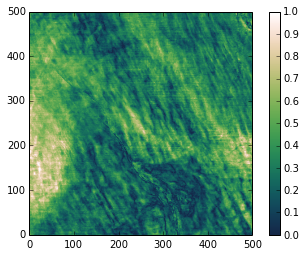

In [15]:
import matplotlib.cm

name  = "matteohelix"
specs = cubehelix(gamma=1.4, start=0.4, rot=-0.8, minLight=0.25)
specs_r = cubehelix(gamma=1.4, start=0.4, rot=-0.8, minLight=0.25, reverse=True)
matplotlib.cm.register_cmap(name=name, cmap=specs)
matplotlib.cm.register_cmap(name=name+"_r", cmap=specs_r)

plt.imshow(ampnorm, origin='bottom', cmap='matteohelix')
plt.colorbar()
plt.show()

Smooth this a bit:

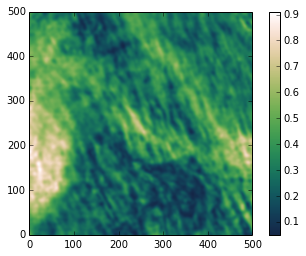

In [16]:
from scipy.ndimage.filters import gaussian_filter
smoothed_amps = gaussian_filter(ampnorm, sigma=3, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

plt.imshow(smoothed_amps, origin='bottom', cmap='matteohelix')
plt.colorbar()
plt.show()

Use the same sigmoid opacity curve [as last time](http://www.agilegeoscience.com/blog/2015/5/27/corendering-attributes-and-2d-colourmaps).

In [17]:
def opaque_transform(x, mu, s):
    """
    Using a cumulative distribution of logistic function:
    http://en.wikipedia.org/wiki/Logistic_distribution
    
    x: the x values    
    mu: std deviation
    s: horizontal shift
    """
    y = 0.5 + 0.5*(np.tanh((x-mu)/s))
    return y

In [18]:
mu = 0.6  # lateral shift
s = 0.2   # steepness of sigmoid (small number = fast)
smoothed_amps = opaque_transform(smoothed_amps, mu, s)

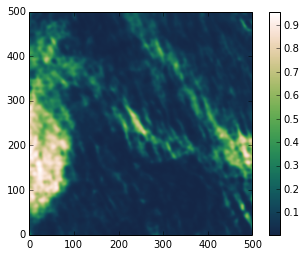

In [19]:
plt.imshow(smoothed_amps, origin='bottom', cmap='matteohelix')
plt.colorbar()
plt.show()

We will use this as an opacity map.

Now we need to assign a colourmap to the z-values, and build the amplitude and similarity images:

In [20]:
from matplotlib.colors import hsv_to_rgb

In [21]:
zcmap = 'matteohelix_r'

# Assign amplitude to the Alpha (opacity) channel
ampRGBA = np.dstack((np.ones_like(ampnorm), np.zeros_like(ampnorm), np.zeros_like(ampnorm), smoothed_amps))

# Assign similarity to the Value channel
simHSV = np.dstack((np.zeros_like(simnorm), np.zeros_like(simnorm), simnorm))
simRGB = hsv_to_rgb(simHSV)
simRGBA = np.dstack((simRGB, np.ones_like(simnorm)))

Make a way to add a scale bar.

In [22]:
from matplotlib.path import Path
import matplotlib.patches as patches

def add_scale(ax, xo=10., yo=-20., dx=40., dy=2.5, spacing=25., units='km'):
    distance = int(spacing * dx / 1000.0)
    verts = [
        (xo, yo), # left, bottom
        (xo, yo+dy), # left, top
        (xo+dx, yo+dy), # right, top
        (xo+dx, yo), # right, bottom
        (0., 0.), # ignored
        ]

    codes = [Path.MOVETO,
             Path.LINETO,
             Path.LINETO,
             Path.LINETO,
             Path.CLOSEPOLY,
             ]

    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='w', lw=1, alpha=0.5)
    patch = ax.add_patch(patch) 
    patch.set_clip_on(False)   # to draw scale outside axes boundary
    ax.text(xo+dx, yo, '  ' + str(distance) + ' ' + units, horizontalalignment='left', verticalalignment='center')

    return ax

Display what we have so far. We are going to combine these into a single map.

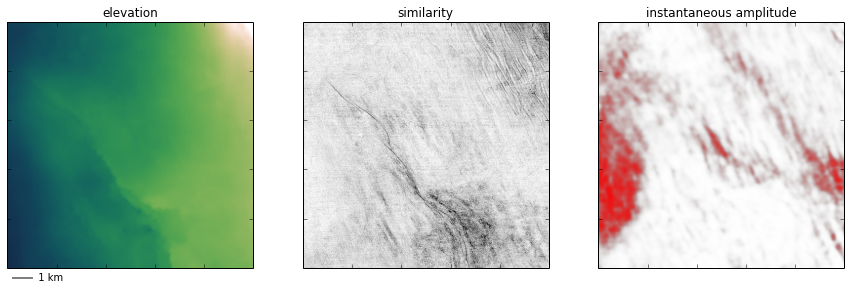

In [24]:
fig, axs = plt.subplots(1,3, figsize=(15,5), facecolor='w')

axs[0].imshow(z, cmap=zcmap, origin='bottom', vmin=750, vmax=1050)
axs[0].set_title('elevation')
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])
axs[0] = add_scale(axs[0])

axs[1].imshow(simRGBA, origin='bottom', vmin=0.5, vmax=1.0)
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])
axs[1].set_title('similarity')

axs[2].imshow(ampRGBA, origin='bottom')
axs[2].set_yticklabels([])
axs[2].set_xticklabels([])
axs[2].set_title('instantaneous amplitude')

#fig.savefig('images/elev_sim_amp_3_panel.png')
plt.show()

## Bump mapping similarity

In [26]:
from matplotlib.colors import LightSource

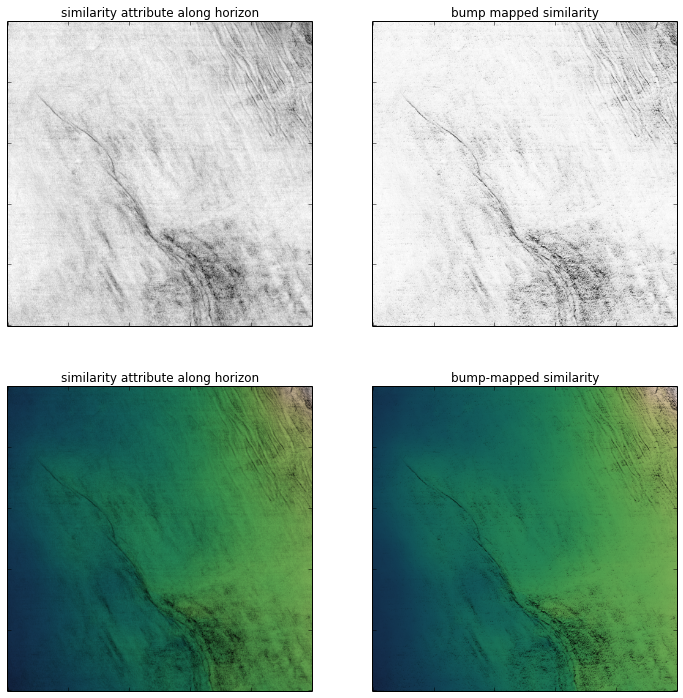

In [32]:
elev_array = plt.get_cmap('matteohelix_r')(znorm)

# example showing how to make shaded relief plots
# like Mathematica
# (http://reference.wolfram.com/mathematica/ref/ReliefPlot.html)
# or Generic Mapping Tools
# (http://gmt.soest.hawaii.edu/gmt/doc/gmt/html/GMT_Docs/node145.html)

# Create light source object.
ls = LightSource(azdeg=350, altdeg=20)

# Shade data, creating an rgb array.
bumps = ls.shade(1-sim, plt.cm.Greys)

# Plot un-shaded and shaded images.
fig, axs = plt.subplots(2,2, figsize=(12,12), facecolor='w')

axs[0][1].imshow(bumps, cmap='Greys_r', origin='bottom')
axs[0][1].set_title('bump mapped similarity')
axs[0][1].set_yticklabels([])
axs[0][1].set_xticklabels([])

axs[1][1].imshow(elev_array*(bumps), origin='bottom')
axs[1][1].set_title('bump-mapped similarity')
axs[1][1].set_yticklabels([])
axs[1][1].set_xticklabels([])

axs[0][0].imshow(simRGBA, origin='bottom')
axs[0][0].set_title('similarity attribute along horizon')
axs[0][0].set_yticklabels([])
axs[0][0].set_xticklabels([])

axs[1][0].imshow(elev_array*simRGBA, origin='bottom')
axs[1][0].set_title('similarity attribute along horizon')
axs[1][0].set_yticklabels([])
axs[1][0].set_xticklabels([])

#plt.savefig('images/bump_mapping.png')
plt.show()

Now we can overlay the amplitude map we already made. 

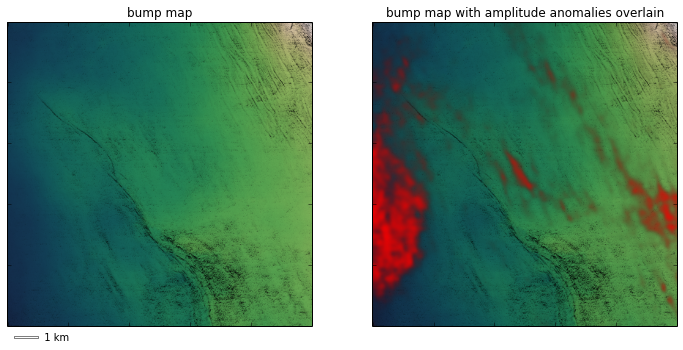

In [33]:
elev_array = plt.get_cmap('matteohelix_r')(znorm)

# example showing how to make shaded relief plots
# like Mathematica
# (http://reference.wolfram.com/mathematica/ref/ReliefPlot.html)
# or Generic Mapping Tools
# (http://gmt.soest.hawaii.edu/gmt/doc/gmt/html/GMT_Docs/node145.html)

# Create light source object.
ls = LightSource(azdeg=350,altdeg=20)

# Shade data, creating an rgb array.
bumps = ls.shade(1-sim, plt.cm.Greys)

# Plot un-shaded and shaded images.
fig, axs = plt.subplots(1,2, figsize=(12,8), facecolor='w')

axs[0].imshow(elev_array*bumps, origin='bottom',cmap='matteohelix')
axs[0].set_title('bump map')
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])
axs[0] = add_scale(axs[0])

axs[1].imshow(elev_array*bumps, origin='bottom', cmap='matteohelix')
axs[1].imshow(ampRGBA, origin='bottom') # this is merely an overlay
axs[1].set_title('bump map with amplitude anomalies overlain')
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])

plt.show()

## Legends

In [34]:
elev_bar = matplotlib.cm.get_cmap('matteohelix_r')

In [35]:
from matplotlib.colors import makeMappingArray

In [36]:
ncolours = 32
elev_arr = makeMappingArray(ncolours, elev_bar)

In [37]:
elev_carr = elev_arr[np.newaxis, :]  

In [38]:
elev_roll = np.rollaxis(elev_carr[:,:,:-1], 1)
elev_bar = np.fliplr(np.rollaxis(elev_roll,1))
elev_bar = np.tile(elev_bar,(5,1,1))

ampramp = np.linspace(-1.0,1.0,32)
ampramp = opaque_transform(ampramp, mu, s)
amp_carr = np.dstack((np.ones_like(ampramp), np.zeros_like(ampramp), np.zeros_like(ampramp), ampramp))
amp_bar = np.tile(amp_carr, (5,1,1))

simramp = np.linspace(0.0,1.0,32)
sim_carr = np.dstack((np.zeros_like(ampramp), np.zeros_like(ampramp), np.zeros_like(ampramp)))
simrgb = hsv_to_rgb(sim_carr)
simrgba = np.dstack((simrgb,simramp))
sim_bar = np.tile(simrgba, (5,1,1))

In [39]:
sim_bar.shape

(5, 32, 4)

Make a checker board style grid so we can see the transparency effect.

In [40]:
check = np.zeros((5, 32))
check[::2, 1::2] = 1
check[1::2, ::2] = 1

Make a function for displaying the colourbars.

In [41]:
def put_colorbars(ax1, ax2, ax3):
    fs = 16 # fontsize for text inside colourbar
    shade_of_grey = 5.0 # increase to make checkers lighter
    ax1.imshow(check, cmap='gray_r', interpolation='nearest', vmax=shade_of_grey)
    ax1.imshow(elev_bar, cmap='matteohelix_r', origin='upper')
    ax1.set_yticks([])
    ax1.set_ylabel('Elevation', rotation=0,ha='right', va='center')
    ax1.text(2.0,2.5,'-', rotation=0, ha='center', va='center', fontsize = fs*1.5, color = 'w')
    ax1.text(29.0,2.5,'+', rotation=0, ha='center', va='center', fontsize = fs)
    ax1.set_xticks([])

    ax2.imshow(check, cmap='gray_r', interpolation='nearest', vmax=shade_of_grey)
    ax2.imshow(np.fliplr(sim_bar))
    ax2.text(2.0,2.5,'-', rotation=0, ha='center', va='center', fontsize = fs*1.5, color='w')
    ax2.text(29.0,2.5,'+', rotation=0, ha='center', va='center', fontsize = fs)
    ax2.set_ylabel('Similarity', rotation=0, ha='right', va='center')
    ax2.set_yticks([])
    ax2.set_xticks([])
    
    ax3.imshow(check, cmap='gray_r', interpolation='nearest', vmax=shade_of_grey)
    ax3.imshow(amp_bar)
    ax3.set_yticks([])
    ax3.set_ylabel('Amplitude', rotation=0, ha='right', va='center')
    ax3.text(2.0,2.5,'-', rotation=0, ha='center', va='center', fontsize = fs*1.5)
    ax3.text(29.0,2.5,'+', rotation=0, ha='center', va='center', fontsize = fs)
    ax3.set_xticks([])
    
    return ax1, ax2, ax3

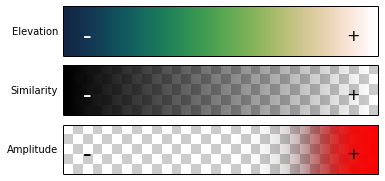

In [42]:
fig = plt.figure(figsize=(8, 3))
ax2 = fig.add_subplot(311)
ax3 = fig.add_subplot(312)
ax4 = fig.add_subplot(313)
ax2, ax3, ax4 = put_colorbars(ax2, ax3, ax4)
plt.show()

## Put everything together

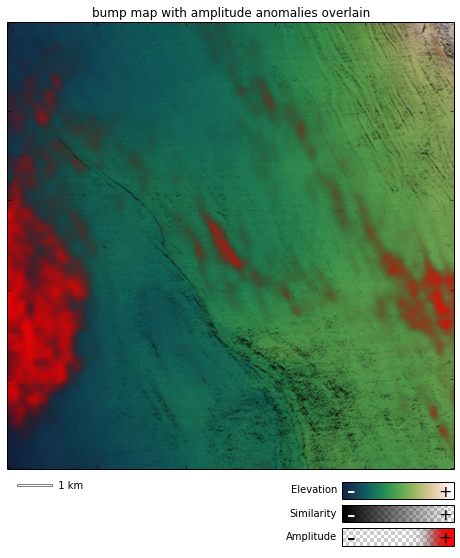

In [44]:
#import matplotlib.gridspec as gridspec
gs = plt.GridSpec(24, 3, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=(8, 10))

ax1 = fig.add_subplot(gs[:22, :])
ax1.imshow(elev_array*bumps, origin='bottom')
ax1.imshow(ampRGBA, origin='bottom') # this is merely an overlay
ax1.set_title('bump map with amplitude anomalies overlain')
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1 = add_scale(ax1)

# 3 colorbars need 3 axes: ax2, ax3, ax4
ax2 = fig.add_subplot(gs[21, 2:])
ax3 = fig.add_subplot(gs[22, 2:])
ax4 = fig.add_subplot(gs[23, 2:])

ax2, ax3, ax4 = put_colorbars(ax2, ax3, ax4)

gs.update(hspace=0.1, wspace=0.5) # this will tighten up the colourbars

#plt.savefig('images/surface_corender.png')
plt.show()

<hr />
<img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" style="float:right;" width="40px" /><p style="color:gray; float:right;">© 2015 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;</p>